In [511]:
import random
from alive_progress import alive_bar, alive_it
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math 
from scipy.fftpack import dct
import pprint
from collections import defaultdict 
from pythonds3.trees import PriorityQueue

def generate_n_colours(n):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(n)]

Notes on bit manipulation in indices calculations of OctTrees:
- right shift = floor dividing the number by 2^shift (think if you did the same to a decimal number then it's divided by 10 essentially) - and vice versa for left shift 
- in bitwise AND operations, if one of the integers have a shorter bit length then it will be padded with 0s to the left to match the other operand's bit length

I think I'm thinking about the bit indexing a bit too much... in the sense that I'm overcomplicating WHY it's done a certain way. Okay. So from wiki, the to obtain the node index we get the different most significant bits of each channel (e.g. 4r + 2g + b). So... the thing that perplexes me a little is HOW the indexing works, which doesn't seem to be explained anywhere. But here are some notes to explain the things I was confused about:

The main thing that confused me a little bit, was why are we shifting each channel by a different amount? Surely that 
doesn't make sense from a calculation standpoint, because we want to look at the same magnitude bits at each level. Key idea is to understand that each bit represents which side of the 
subcube we stand at (because an Octree is essentially created by dividing each subcube's dimensions in half and then allocating children points to the different centres created, we can think of each bit as which half the point should be at at each level.) BUT. just thinking about it more simply, the different shift amounts is just because we want to create the end bits more easily. What we are doing here:
```
def compute_index(self, r, g, b, l):
    # what level of division are we looking at? - caps at 8 because value <= 255
    shift = 8 - l
    # Different shift values below are just to position the resulting bit in the correct position
    # in the final bitwise OR. 
    rc = r >> shift - 2 & 0x4
    gc = g >> shift - 1 & 0x2
    bc = b >> shift & 0x1
    return rc | gc | bc
```

is really the same as:
```
def computer_index(self, r, g, b, l):
    shift = 8-l 
    # This results in the same thing, where we first grab the bit of interest, then 
    # shift it to the desired position
    rc = (r >> shift & 0x1) <<  2
    gc = (g >> shift & 0x1) << 1
    bc = b >> shift & 0x1
    return rc | gc | bc
```

I think if I was more familiar with bit manipulation I wouldn't have thought in the wrong direction for so long... :( But good learning!
    

In [90]:
def compute_index(r, g, b, l):
    # what level of division are we looking at? - caps at 8 because value <= 255
    shift = 8 - l
    # Different shift values below are just to position the resulting bit in the correct position
    # in the final bitwise OR. 
    # If l has a possibility of exceeding 6, this version also acts as a control point 
    # because for example if l = 7, the r shift will be negative, which will raise an error.
    rc = r >> shift - 2 & 0x4
    gc = g >> shift - 1 & 0x2
    bc = b >> shift & 0x1
    return rc | gc | bc

def compute_index_2(r, g, b, l):
    shift = 8-l 
    # This results in the same thing, where we first grab the bit of interest, then 
    # shift it to the desired position
    rc = (r >> shift & 0x1) <<  2
    gc = (g >> shift & 0x1) << 1
    bc = b >> shift & 0x1
    return rc | gc | bc

#check that the two functions are equivalent 
n_points = 100_000
for _ in alive_it(range(n_points), force_tty=True):
    l  = random.randrange(7)
    r = random.randrange(256)
    g = random.randrange(256)
    b = random.randrange(256)
    assert compute_index(r, g, b, l) == compute_index_2(r, g, b, l)

|████████████████████████████████████████| 100000/100000 [100%] in 1.3s (78726.58/s)                    00000 [73%] in 1s (78466.7/s, eta: 0s) ▃▁▃ 89600/100000 [90%] in 1s (78563.3/s, eta: 0s)                 


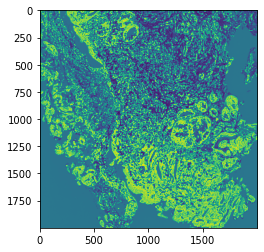

In [211]:
"""
Optional activity: implement a JPEG compression? and decode as well

1. colour space transform to YcbCr, and then downsampling the colour space (like in octrees kind of, 
   but directly by combining subcubes)
2. DCT compression
3. Huffman Encoding

Won't implement everything according to the standard, but just want to learn about each step.
https://www.youtube.com/watch?v=0me3guauqOU&ab_channel=Reducible <- SUPER HELPFUL
"""

img = cv2.imread('Da389.jpg', 0)
img -= 128
plt.imshow(img)

[[ 0.00000000e+00  2.22044605e-16 -1.11022302e-16  3.33066907e-16
  -2.22044605e-16]
 [ 2.22044605e-16  0.00000000e+00  0.00000000e+00 -2.22044605e-16
   1.66533454e-16]
 [-1.11022302e-16  0.00000000e+00  0.00000000e+00  2.77555756e-16
  -3.05311332e-16]
 [ 3.33066907e-16 -2.22044605e-16  2.77555756e-16  0.00000000e+00
   3.88578059e-16]
 [-2.22044605e-16  1.66533454e-16 -3.05311332e-16  3.88578059e-16
   0.00000000e+00]]


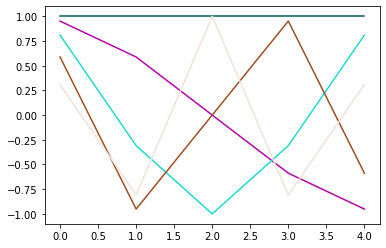

In [210]:
#This cell we're just examining the cos term in the equation to calculate DCT-II coefficients
N = 5
#this is essentially sampling N points from N cos waves ranging from cos(0) -> cos((N-1)x)
cos_waves = [[math.cos((pt + 0.5) * math.pi * k / N) for pt in range(N)] for k in range(N)]

for cos, col in zip(cos_waves, generate_n_colours(N)):
    plt.plot(cos, col)

#the waves are supposed to be orthogonal to each other, so we can check that as well 
ortho = np.zeros((N, N))
for a in range(N):
    for b in range(N):
        if a != b:
            ortho[a,b] = np.dot(cos_waves[a], cos_waves[b])

print(ortho)
#values are realllyyy close to zero, so given rounding errors we can see that that is true 


In [274]:
#let's build the 1d DCT first and see how that goes 
"""
Intuition of DCT: 
essentially, dct is a signal transformation method. let's take a row of an image. The points formed by the 
values creates a 1d vector. If we plot it out, it will look like some random curve perhaps. The point of 
DCT is that we're trying to represent the vector as the sum of different cos waves. (The theory I suppose
dictates that if you have n points in your vector, n cos waves will be sufficient to recreate it. 
e.g. if you have 8 points, 
a*cos(0) b*(constant) + c*cos(x) + d*cos(2x) + e*cos(3x) ... + h*cos(8x), where a-h are coefficients that
we're trying to find.

So how do we find these coefficients? In a vector of 8 points for example, we can also sample 8 points 
from each cosine wave - perhaps by dividing the interval by n and sampling the mid-points 

We then calculate the dot product between the cosine vector and our vector of interest to see how similiar it is.
(dot product is equal to the summation term in the equation)
"""

def generate_cos_matrix(n):
    return np.array([[math.cos((pt + 0.5) * math.pi * k / n) for pt in range(n)] for k in range(n)])

def dct_1d(vec, cos_waves=None):
    #first we want the length of the vector - we won't restrict the length of the vector here 
    n = len(vec)
    # for n waves, we have to sample n points - in dct II, we essentially
    # divide the interval (180 / math.pi) into N segments, and sample the midpoint (hence the + 0.5)
    if cos_waves is None:
        cos_waves = generate_cos_matrix(n)
    # res = np.array([np.dot(vec, cos) for cos in cos_waves])
    res = np.matmul(cos_waves, vec) #same as the list comp!
    #the fact that dct can be represented as a matrix multiplication signals that it's a linear transformation
    return res 

def dct_2d(arr):
    #dct1d horizontally first, then vertically
    h_cos_waves = generate_cos_matrix(arr.shape[0])
    w_cos_waves = generate_cos_matrix(arr.shape[1])
    res = np.stack([dct_1d(arr[row, :], cos_waves=h_cos_waves) for row in range(arr.shape[0])], axis=0)
    res = np.stack([dct_1d(res[:, col], cos_waves=w_cos_waves) for col in range(arr.shape[1])], axis=1)
    return res 

def inverse_dct_1d(coeffs, cos_waves=None):
    if cos_waves is None:
        cos_waves = generate_cos_matrix(len(coeffs))
    #by inverting the cos waves matrix, we are turning each COLUMN into cos waves vs each row 
    #then, when we do matmul, we are summing at each point the coeff * cos wave, to get the original 
    #wave back
    return np.matmul(np.linalg.inv(cos_waves), coeffs)

In [297]:
"""
quantization - essentially we divide the coeffs with a table, where top left divisors are smaller, and 
progressively gets larger as we get to bottom right. After forcing the values to be ints, a lot of the 
higher frequency components (closer to lower right) will zero out (they are start out with smaller 
values typically.) So the act of doing that is quantization!
"""

def calc_q_table(shape, factor=1, min_val=1, max_val=999):
    #we're going to take the JPEG default 8x8 quantization table, and upscale to our image size
    #https://users.cs.cf.ac.uk/dave/Multimedia/node237.html
    default = np.array(
        [[16, 11 ,10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]], dtype=np.float32)
    #we just use a straightward scalar to change how aggressive the values are - in practice it's probs different?
    return np.clip(cv2.resize(default, shape).astype(np.int32) * factor, min_val, max_val)

def quantization(mat, q_table):
    scaled = mat / q_table
    return scaled.astype(np.int32)
    

In [489]:
test_img = img[:10, :10]
coeffs = dct_2d(test_img)
q_table = calc_q_table(test_img.shape, factor=5)
quantized = quantization(coeffs, q_table)
print(quantized)

[[162  19  -2 -21   8  -3   3   0  -2  -2]
 [-43 -15  -9   4 -16   4   3   0  -2   0]
 [-11 -11   1   6  -2   4  -2   2   0  -1]
 [  0   3   6  -6   3   0  -2   0   0   0]
 [ 10   5   2  -4   2   0   0   0   0   1]
 [  1   0  -1   0   1   0   0   1  -1   0]
 [ -4  -2   0   0   0   0   0   1  -1   0]
 [ -4   0   0   0  -1   0   1   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0]]


In [490]:
"""
Run-length encoding + Huffman encoding (lossless encoding)

run-length encoding takes advantage of the fact that typically after quantization, we have a lot of zeros. 
If we turn the quantized matrix into a vector by doing a zig zag scan, we can get a lot of consecutive zeros 
together in the vector, which can then be compressed using run-length encoding 
"""

def in_bounds(pos, h, w):
    return 0 <= pos[0] < h and 0 <= pos[1] < w

def zig_zag_encode(arr):
    #key thing here is that points on the same diagonal share the same sum, so 
    #we can use that to identify what we should do at odd and even diagonals
    # - zig zag sequence follows the reducible video 
    pos = [0, 0]
    h, w = arr.shape
    res = [] 
    while pos != [h-1,w-1]:
        res.append(arr[tuple(pos)])
        if sum(pos) % 2 == 0:
            next_pos = [pos[0]-1, pos[1]+1]
            if in_bounds(next_pos, h, w):
                pos = next_pos 
            else:        
                # detect edge case where we are at the rightmost of array
                # if so we shift down                
                if pos[1] + 1 < w:
                    pos[1] += 1
                else:
                    pos[0] += 1
        else:
            next_pos = [pos[0]+1, pos[1]-1]
            if in_bounds(next_pos, h, w):
                pos = next_pos 
            else:
                # detect edge case where we are at the bottom of array
                # if so we shift right
                if pos[0] + 1 < h:
                    pos[0] += 1
                else:
                    pos[1] += 1
    res.append(arr[tuple(pos)])
    return res


zig_zag = zig_zag_encode(quantized)
pp = pprint.PrettyPrinter(indent=0, width=55, compact=True)
pp.pprint(zig_zag)

[162, 19, -43, -11, -15, -2, -21, -9, -11, 0, 10, 3, 1,
4, 8, -3, -16, 6, 6, 5, 1, -4, 0, 2, -6, -2, 4, 3, 0,
3, 4, 3, -4, -1, -2, -4, 4, 0, 0, 0, 2, 0, -2, 0, -2,
-2, -2, 2, -2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
-1, 1, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0]


In [491]:
def zig_zag_decode(vec, shape):
    h,w = shape 
    res = np.zeros(shape)
    pos = [h-1, w-1]
    res[h-1, w-1] = vec[-1]

    for i in range(len(vec)-2, -1, -1):
        if sum(pos) % 2 == 0:
            next_pos = [pos[0]+1, pos[1]-1]
            if in_bounds(next_pos, h, w):
                pos = next_pos 
            else:
                if pos[1] - 1 >= 0:
                    pos[1] -= 1 
                else:
                    pos[0] -= 1
        else:
            next_pos = [pos[0]-1, pos[1]+1]
            if in_bounds(next_pos, h, w):
                pos = next_pos 
            else:
                if pos[0] - 1 >= 0:
                    pos[0] -= 1
                else:
                    pos[1] -= 1
        res[tuple(pos)] = vec[i]
    return res

decoded_zz = zig_zag_decode(zig_zag, quantized.shape)
decoded_zz

array([[162.,  19.,  -2., -21.,   8.,  -3.,   3.,   0.,  -2.,  -2.],
       [-43., -15.,  -9.,   4., -16.,   4.,   3.,   0.,  -2.,   0.],
       [-11., -11.,   1.,   6.,  -2.,   4.,  -2.,   2.,   0.,  -1.],
       [  0.,   3.,   6.,  -6.,   3.,   0.,  -2.,   0.,   0.,   0.],
       [ 10.,   5.,   2.,  -4.,   2.,   0.,   0.,   0.,   0.,   1.],
       [  1.,   0.,  -1.,   0.,   1.,   0.,   0.,   1.,  -1.,   0.],
       [ -4.,  -2.,   0.,   0.,   0.,   0.,   0.,   1.,  -1.,   0.],
       [ -4.,   0.,   0.,   0.,  -1.,   0.,   1.,   0.,   0.,   0.],
       [  4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [498]:
"""
run length encoding - we won't follow the convention of jpeg here, just normal rle
jpeg style encoding:
[(r,s), c]
r - number of 0's preceding value 
s - number of bits needed to encode value c 
c - coefficient value 
(0,0) used to indicate the end of a block
"""
def run_length_encoding(vec):
    zero_count = 0
    res = []
    for val in vec:
        if val == 0:
            zero_count += 1 
        else:
            if zero_count > 0:
                zeros = f'0[x{zero_count}]' if zero_count > 1 else 0
                res.append(zeros)
            zero_count = 0
            res.append(val)
    if zero_count > 0:
        zeros = f'0[x{zero_count}]' if zero_count > 1 else 0
        res.append(zeros)
    return res

rle = run_length_encoding(zig_zag)
pp.pprint(rle)

[162, 19, -43, -11, -15, -2, -21, -9, -11, 0, 10, 3, 1,
4, 8, -3, -16, 6, 6, 5, 1, -4, 0, 2, -6, -2, 4, 3, 0,
3, 4, 3, -4, -1, -2, -4, 4, '0[x3]', 2, 0, -2, 0, -2,
-2, -2, 2, -2, 0, 1, '0[x3]', 2, '0[x9]', -1, '0[x4]',
-1, '0[x6]', 1, '0[x2]', 1, -1, 1, 1, '0[x5]', -1,
'0[x11]']


In [584]:
"""
https://www.youtube.com/watch?v=B3y0RsVCyrw <- Reducible video! super good
Huffman Encoding: The basic idea is that we want to encode very frequent symbols (ie. pixel values / run-length encodings) with smaller bits,
and infrequent symbols with larger bits to achieve compression. (The lower bound for how much we can compress a certain categorical distribution
is the entropy of the distribution (proof here: https://mbernste.github.io/posts/sourcecoding/ but I need to learn about langragian multipliers
to understand the solution to the optimization problem))
The basic idea is that we build a binary tree, where if a right child represents adding a 1 to the code word, and left child adds a 0 to the code word.
How do we build this tree? We basically examine the frequency of each symbol within our current distribution. We take the most infrequent pair (ordered
using a min priority queue), and group them together to form a node. This internal node is then reinserted into the priority queue, and the process
is repeated until the queue has 2 nodes left, at which point we put the final two nodes under the root node. 
"""

class HuffmanTree:
    def __init__(self, root):
        self.root = root 
        self.codes = {}
        self.generate_codes()

    def encode(self, vec):
        return ''.join([self.get_code_word(sym) for sym in vec])

    def get_code_word(self, sym):
        return self.codes[sym]

    def decode(self, code):
        vec = []
        curr = self.root 
        for val in code:
            if int(val):
                curr = curr.right_child 
            else:
                curr = curr.left_child 
            
            if curr.sym is not None:
                vec.append(curr.sym)
                curr = self.root 
        return vec

    def generate_codes(self):
        self.traverse(self.root, '')

    def traverse(self, node, curr_code):
        if node:
            if node.sym is not None:
                self.codes[node.sym] = curr_code 
            self.traverse(node.left_child, curr_code + '0')
            self.traverse(node.right_child, curr_code + '1')

class HuffmanNode:
    def __init__(self, sym=None, freq=None, left_child=None, right_child=None):
        self.sym = sym
        self.freq = freq 
        self.left_child = left_child
        self.right_child = right_child

    def __lt__(self, other_node):
        return self.freq < other_node.freq 

    def __gt__(self, other_node):
        return self.freq > other_node.freq


def huffman_encode(vec):
    freqs = defaultdict(lambda: 0)
    for sym in vec:
        freqs[sym] += 1 

    pq = PriorityQueue()
    #check if this is valid?
    pq.heapify([(freq, HuffmanNode(sym=sym, freq=freq)) for sym,freq in freqs.items()])

    while len(pq) > 1:
        _, node_1 = pq.delete()
        _, node_2 = pq.delete()

        #ordering of left or right does not matter in the construction
        #of huffman tree, unlike in shannon-fano tree, because
        #we're always combining the smallest possible 2 nodes anyway
        new_node = HuffmanNode(freq=node_1.freq+node_2.freq, left_child=node_1, right_child=node_2)
        pq.insert((new_node.freq, new_node))

    tree = HuffmanTree(root=pq.delete()[1])
    return tree 


In [585]:
tree = huffman_encode(rle)

In [586]:
code = tree.encode(rle)

In [588]:
assert rle == tree.decode(code)

In [275]:
class JPEGLike_Base:
    def __init__(self, fpath, greyscale=True):
        self.fpath = fpath 
        self.greyscale = greyscale 
        self.img = cv2.imread(self.fpath, not self.greyscale)
        if not self.greyscale:
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)        

In [272]:
class JPEGLike_Encoder(JPEGLike_Base):
    def __init__(self, fpath, greyscale=True):
        super().__init__(fpath, greyscale=greyscale)        

In [273]:
class JPEGLike_Decoder:
    def __init__(self, fpath, greyscale=True):
        super().__init__(fpath, greyscale=greyscale)